# eQQMIX : Entangled Quantum QMIX Algorithm -- eQVDN

Multi-agent learning by deriving $Q_{tot}$ from GHZ-entangled agent PQCs and joint measurements.

Inspired by the tutorial: https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning#3_deep_q-learning_with_pqc_q-function_approximators

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

# from eqmarl import *
import cirq
import sympy
import tensorflow_quantum as tfq
import pennylane as qml
import numpy as np
import functools as ft
import collections as cl
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import gymnasium as gym
from pathlib import Path
from PIL import Image

2024-01-12 16:55:56.341205: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [4]:
# List information about PennyLane plugins.
qml.about()

Name: PennyLane
Version: 0.33.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /usr/local/Caskroom/miniforge/base/envs/eqmarl/lib/python3.9/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-Cirq, PennyLane-Lightning

Platform info:           macOS-14.1.1-x86_64-i386-64bit
Python version:          3.9.18
Numpy version:           1.26.1
Scipy version:           1.11.3
Installed devices:
- default.gaussian (PennyLane-0.33.0)
- default.mixed (PennyLane-0.33.0)
- default.qubit (PennyLane-0.33.0)
- default.qubit.autograd (PennyLane-0.33.0)
- default.qubit.jax (PennyLane-0.33.0)
- default.qubit.legacy (PennyLane-0.33.0)
- default.qubit.tf (PennyLane-0.33.0)
- default.qubit.torch (PennyLane-0.33.0)
- default

In [5]:
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def catchtime() -> float:
    start = perf_counter()
    yield lambda: perf_counter() - start


# with catchtime() as t:
#     import time
#     time.sleep(1)

# print(f"Execution time: {t():.4f} secs")

In [6]:




# class ParameterizedOperation(cirq.Gate):
#     """Performs a list of parameterized operations on each qubit.
    
#     Implements `shape()` to determine parameter shapes.
#     """
#     operations: list[type[cirq.Operation]] = [] # Default is no operations, which will throw an error; users must override this or provide an operations list at runtime.
    
#     def __init__(self, 
#         weights: np.ndarray,
#         # wires: list,
#         id: str = None,
#         operations: list[type[cirq.Operation]] = None,
#         ):
        
#         # Ensure weights have proper shape.
#         req_shape = self.shape(wires, operations)
#         n_req_shape = len(req_shape)
#         weights_shape = qml.math.shape(weights)
#         n_weights_shape = len(weights_shape)
#         assert n_weights_shape == n_req_shape or n_weights_shape == n_req_shape + 1, (
#             f"Weights tensor must be {n_req_shape}-dimensional with shape {req_shape}"
#             f"or {n_req_shape+1}-dimensional if batching; got shape {weights_shape}"
#         )
        
#         # Validate operations.
#         operations = operations or self.operations
#         assert len(operations) > 0, 'at least one operation is required'
        
#         self._hyperparameters = {"operations": operations}
#         super().__init__(weights, wires=wires, id=id)


#     def call(self, weights, wires):
#         # Decompose rotations into operations.
#         op_list = []
#         for i, wire in enumerate(wires):
#             for j, op in enumerate(self.operations):
#                 op_list.append(op(weights[..., i, j], wires=wire))

#         return op_list

#     # @staticmethod
#     @classmethod
#     def compute_decomposition(cls,
#         weights: np.ndarray,
#         wires: list,
#         operations: list[cirq.Operation],
#         ):

#         # Decompose rotations into operations.
#         op_list = []
#         for i, wire in enumerate(wires):
#             for j, op in enumerate(operations):
#                 op_list.append(op(weights[..., i, j], wires=wire))

#         return op_list

#     @classmethod
#     def shape(cls,
#         wires: list,
#         operations: list[cirq.Operation] = None,
#         ):
#         """Returns tuple of (n_wires, n_operations).
        
#         If no operations are provided then defaults to class operations.
        
#         Note that the returned shape does not include a batch dimension.
#         """

#         # Use default operations for class instance if none were provided.
#         if operations is None: 
#             operations = cls.operations
        
#         if isinstance(wires, (int, str)):
#             wires = [wires]
        
#         return (len(wires), len(operations),)



class ParameterizedOperationGate(cirq.Gate):
    """
    Applies a sequence of gates corresponding to a parameter matrix. By default gates are assumed to operate on single qubits. Every row of the parameter matrix is a separate set of qubits on which to apply the operation sequence.
    """
    
    operations: list[cirq.Gate] = []
    
    def __init__(self, theta: np.ndarray, name: str = None):
        super().__init__()
        self.theta = theta
        self.name = name or self.__class__.__name__
        
    def _num_qubits_(self):
        return self.theta.shape[0]

    def _decompose_(self, qubits):
        # for i, q in enumerate(qubits):
        #     yield cirq.rx()
        
        # print(f"{self.theta=}")
            
        # Decompose rotations into operations.
        for i, q in enumerate(qubits):
            for j, op in enumerate(self.operations):
                yield op(self.theta[..., i, j])(q)
                
    def _circuit_diagram_info_(self, args):
        # return f"R({self.theta})"
        # print(args)
        return [f'{self.name}({self.theta[i]})' for i in range(self.theta.shape[0])]
    
    @classmethod
    def get_shape(cls,
        n_qubits: int,
        operations: list[cirq.Gate] = None,
        ):
        """Returns tuple of (n_wires, n_operations).
        
        If no operations are provided then defaults to class operations.
        
        Note that the returned shape does not include a batch dimension.
        """

        # Use default operations for class instance if none were provided.
        if operations is None: 
            operations = cls.operations
        
        # if isinstance(qubits, (int, str)):
        #     qubits = [qubits]
        
        return (n_qubits, len(operations),)


class VariationalRotationLayer(ParameterizedOperationGate):
    """Parameterized variational rotation layer.
    
    Implements `shape()` to determine parameter shapes.
    """
    operations = [cirq.rx, cirq.ry, cirq.rz] # Default is 3 rotation sequence RX, RY, RZ.


class EncodingLayer(ParameterizedOperationGate):
    """Parameterized variational rotation layer.
    
    Implements `shape()` to determine parameter shapes.
    """
    operations = [cirq.rx]


def circular_entangling_layer(
    qubits: list,
    gate: cirq.Gate = cirq.CZ,
    ) -> list[cirq.Operation]:
    """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
    ops = []
    for q0, q1 in zip(qubits, qubits[1:]):
        ops.append(gate(q0, q1))
    if len(qubits) != 2:
        ops.append(gate(qubits[0], qubits[-1])) # Entangle the first and last qubit.
    return ops
    # for w0, w1 in zip(wires, wires[1:]):
    #     ops.append(gate(wires=[w0, w1]))
    # if len(wires) != 2:
    #     ops.append(gate(wires=[wires[0], wires[-1]])) # Entangle the first and last qubit.
    # return ops



def generate_variational_encoding_circuit(
    qubits: list,
    n_layers: int,
    decompose: bool = False,
    ) -> tuple[cirq.Circuit, tuple[np.ndarray,...]]:
    
    n_qubits = len(qubits)
    
    shape_var = VariationalRotationLayer.get_shape(n_qubits)
    shape_enc = EncodingLayer.get_shape(n_qubits)
    
    ### Define weights for circuit.
    #
    ## Variational shape
    theta_var = sympy.symbols(f'var(0:{n_layers+1})_' + '_'.join(f'(0:{x})' for x in shape_var))
    theta_var = np.asarray(theta_var).reshape((n_layers+1, *shape_var))
    ## Encoding shape
    theta_enc = sympy.symbols(f'enc(0:{n_layers})_' + '_'.join(f'(0:{x})' for x in shape_enc))
    theta_enc = np.asarray(theta_enc).reshape((n_layers, *shape_enc))
    
    # Build the circuit.
    # circuit = cirq.Circuit()
    ops = []
    for l in range(n_layers):
        # Variational layer.
        ops.append(
            VariationalRotationLayer(theta_var[l], name=f'v{l}')(*qubits)
        )
        
        # Entangling layer.
        ops.append(
            circular_entangling_layer(qubits)
        )
        
        # Encoding layer.
        ops.append(
            EncodingLayer(theta_enc[l], name=f'e{l}')(*qubits)
        )
    # Last variational layer at the end.
    ops.append(
        VariationalRotationLayer(theta_var[l+1], name=f'v{l+1}')(*qubits)
    )
    
    # Decompose circuit into minimal gate representation.
    # This is required when custom gates are implemented for use with TensorFlowQuantum
    if decompose:
        ops = [cirq.decompose(o) for o in cirq.ops.flatten_to_ops(ops)]

    circuit = cirq.Circuit(ops)

    return circuit, (theta_var, theta_enc)
    
    
qubits = cirq.LineQubit.range(4)
# qubits

circuit, _ = generate_variational_encoding_circuit(qubits, 5, decompose=True)
circuit

# shape_var = VariationalRotationLayer.get_shape(qubits)
# theta_var = np.random.random(size=shape_var)

# shape_enc = EncodingLayer.get_shape(qubits)
# theta_enc = np.random.random(size=shape_enc)

# # VariationalRotationLayer(theta_var, name='vr')(*qubits)

# circuit = cirq.Circuit()
# circuit += VariationalRotationLayer(theta_var)(*qubits)
# circuit += EncodingLayer(theta_enc)(*qubits)

# print(circuit)

┌──────────────────────────────────┐                                                                                                                                                                                               ┌──────────────────────────────────┐                                                                                                                                                                                               ┌──────────────────────────────────┐                                                                                                                                                                                               ┌──────────────────────────────────┐                                                                                                                                                                                               ┌──────────────────────────────────┐
0: ───Rx(0.318309886183791*pi*var0_0_0)───Ry(0.318309886183791*pi*var0_0_1)───Rz(0.318309886183791*pi*var0_0_2)───@────────────────────────────────────────────@─────────────────────────────────────Rx(0.318309886183791*pi*enc0_0_0)───Rx(0.318309886183791*pi*var1_0_0)───Ry(0.318309886183791*pi*var1_0_1)───Rz(0.318309886183791*pi*var1_0_2)───@────────────────────────────────────────────@─────────────────────────────────────Rx(0.318309886183791*pi*enc1_0_0)───Rx(0.318309886183791*pi*var2_0_0)───Ry(0.318309886183791*pi*var2_0_1)───Rz(0.318309886183791*pi*var2_0_2)───@────────────────────────────────────────────@─────────────────────────────────────Rx(0.318309886183791*pi*enc2_0_0)───Rx(0.318309886183791*pi*var3_0_0)───Ry(0.318309886183791*pi*var3_0_1)───Rz(0.318309886183791*pi*var3_0_2)───@────────────────────────────────────────────@─────────────────────────────────────Rx(0.318309886183791*pi*enc3_0_0)───Rx(0.318309886183791*pi*var4_0_0)───Ry(0.318309886183791*pi*var4_0_1)───Rz(0.318309886183791*pi*var4_0_2)───@────────────────────────────────────────────@─────────────────────────────────────Rx(0.318309886183791*pi*enc4_0_0)───Rx(0.318309886183791*pi*var5_0_0)───Ry(0.318309886183791*pi*var5_0_1)───Rz(0.318309886183791*pi*var5_0_2)───
                                                                                                                  │                                            │                                                                                                                                                                                     │                                            │                                                                                                                                                                                     │                                            │                                                                                                                                                                                     │                                            │                                                                                                                                                                                     │                                            │
1: ───Rx(0.318309886183791*pi*var0_1_0)───Ry(0.318309886183791*pi*var0_1_1)───Rz(0.318309886183791*pi*var0_1_2)───@───@───Rx(0.318309886183791*pi*enc0_1_0)────┼Rx(0.318309886183791*pi*var1_1_0)────Ry(0.318309886183791*pi*var1_1_1)───Rz(0.318309886183791*pi*var1_1_2)───────────────────────────────────────────────────────────────────────────@───@───Rx(0.318309886183791*pi*enc1_1_0)────┼Rx(0.318309886183791*pi*var2_1_0)────Ry(0.318309886183791*pi*var2_1_1)───Rz(0.318309886183791*pi*var2_1_2)───────────────────────────────────────────────────────────────────────────@───@───Rx(0.318309886183791*pi*enc2_1_0)────┼Rx(0.318309886183791*pi*var3_1_0)────Ry(0.318309886183791*pi*var3_1_1)───Rz(0.318309886183791*pi*var3_1_2)────────────────

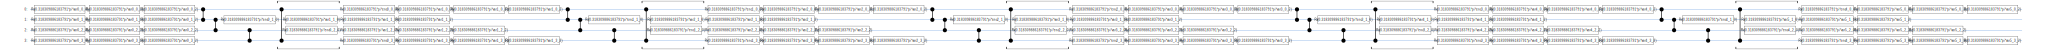

In [7]:
from cirq.contrib.svg import SVGCircuit
SVGCircuit(circuit)

In [8]:
class HybridVariationalEncodingPQC(keras.layers.Layer):
    
    def __init__(self, 
        qubits: list,
        n_layers: int,
        observables: list,
        name: str = None,
        squash_activation: str = 'linear',
        ):
        name = name or self.__class__.__name__
        super().__init__(name=name)
        
        self.n_layers = n_layers
        self.n_qubits = len(qubits)
        self.squash_activation = squash_activation
        
        # Build circuit.
        circuit, (symbols_var, symbols_enc) = self.generate_circuit(qubits, n_layers, decompose=True)
        
        # Define trainable variables for TensorFlow layer.
        self.w_var = tf.Variable(
            initial_value=tf.random_uniform_initializer(minval=0.0, maxval=np.pi)(shape=symbols_var.shape, dtype='float32'),
            trainable=True,
            name='w_var',
        )
        self.w_enc = tf.Variable(
            initial_value=tf.ones(shape=symbols_enc.shape, dtype='float32'),
            trainable=True,
            name='w_enc',
        )
        
        # Explicit symbol ordering.
        self.symbols = [str(s) for s in np.concatenate((symbols_var.flatten(), symbols_enc.flatten()))]
        self.symbols_idx = tf.constant([self.symbols.index(s) for s in sorted(self.symbols)]) # Cross-ref symbol with its index in the explicit ordering.
        
        # Empty circuit for batching.
        self.empty_circuit_tensor = tfq.convert_to_tensor([cirq.Circuit()])
        
        # The variational+encoding circuit for computation.
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)
        
    def call(self, inputs):
        batch_size = tf.gather(tf.shape(inputs), 0)
        
        # Since input is batched, we must batch the TFQ circuits.
        batched_circuits = tf.repeat(self.empty_circuit_tensor, repeats=batch_size)
        
        # Batch the variational weight angles.
        angles_var = tf.reshape(tf.tile(self.w_var, multiples=[batch_size, 1, 1]), shape=(-1, *self.w_var.shape))
        
        # Multiply input vectors by the encoding weights.
        # Preserves batching.
        # Einsum dimension labels:
        #   b = batch
        #   l = layer
        #   q = qubit
        #   f = feature
        angles_enc = tf.einsum("lqf,bq->blqf", self.w_enc, inputs)
        
        # Squash the encoding input angles using the provided activation function.
        angles_enc = keras.layers.Activation(self.squash_activation)(angles_enc)
        
        
        # Combine all angles into a single batched tensor.
        # This is necessary because TensorFlowQuantum requires parameters to be in 1D list format. Since the circuits are also batched, this turns into 2D with shape (batch_size, num_symbols).
        #
        # Since all angles are different shapes, compress each down to batched 2D and then concatenate along the feature dimension.
        joined_angles = tf.concat([
            tf.reshape(angles_var, (batch_size, -1)),
            tf.reshape(angles_enc, (batch_size, -1)),
        ], axis=1)
        #
        # Now reorder angles based on explicit symbol ordering.
        joined_angles = tf.gather(joined_angles, self.symbols_idx, axis=1)
        
        # Run batched angles.
        # Result will be 2D with shape (batch_size, num_observables).
        out = self.computation_layer([batched_circuits, joined_angles])
        
        return out
    
    @staticmethod
    def generate_circuit(*args, **kwargs):
        return generate_variational_encoding_circuit(*args, **kwargs)
    
    
observables = [
    cirq.Z(qubits[0]) * cirq.Z(qubits[1]),
    cirq.Z(qubits[2]) * cirq.Z(qubits[3]),
]
    
layer = HybridVariationalEncodingPQC(qubits, 5, observables, squash_activation='tanh')
layer.w_var.shape, layer.w_enc.shape, layer.symbols, layer.symbols_idx


x = np.random.random(size=(16,4,))
layer(x)

<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[ 0.01745525,  0.10810581],
       [ 0.3009823 , -0.11701147],
       [ 0.14866196, -0.1907006 ],
       [ 0.20163324,  0.08790958],
       [-0.12392092, -0.16998743],
       [ 0.14271474,  0.16371481],
       [ 0.10464965, -0.05828256],
       [ 0.20110786, -0.17766742],
       [ 0.23662487,  0.22041366],
       [ 0.2873416 ,  0.1641842 ],
       [ 0.16659059,  0.01791796],
       [ 0.29541832,  0.26349494],
       [-0.05352817, -0.22294943],
       [ 0.14184454, -0.16593295],
       [-0.07891774, -0.03741387],
       [ 0.11522146, -0.23346977]], dtype=float32)>

In [9]:
class Rescaling(keras.layers.Layer):
    """Learnable rescaling from range [-1, 1] to range [0, 1]."""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)),
            dtype='float32',
            trainable=True,
            name='obs-weights',
            )
        
    def call(self, inputs):
        # inputs = tf.math.abs(inputs)
        # inputs = tf.cast(inputs, dtype='float32')
        return tf.math.multiply(
            (1+inputs)/2., # Rescale from [-1, 1] to range [0, 1].
            tf.repeat(self.w, repeats=tf.shape(inputs)[0], axis=0),
            )

In [10]:
def generate_model_Qlearning(qubits, n_layers, observables, is_target):
    
    n_wires = len(qubits)
    
    # qubits = cirq.LineQubit.range(n_wires)
    
    qlayer = HybridVariationalEncodingPQC(qubits, n_layers, observables, squash_activation='tanh')

    model = keras.Sequential([
            keras.Input(shape=(n_wires,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            qlayer,
            # CustomQuantumLayer(n_wires, n_layers, observables),
            # keras.layers.Lambda(lambda x: tf.math.abs(x)), # Convert complex to float via abs.
            # keras.layers.Activation('tanh'), # Ensure outputs of PQC are in range [-1, 1].
            keras.Sequential([Rescaling(len(observables))], name=is_target*'Target'+'Q-values'),
        ],
        )
    return model
    

In [11]:
n_actions = 2 # because `env.action_space.n == 2`
n_wires = 4 # because `env.observation_space.shape == (4,)`
n_layers = 5

qubits = cirq.LineQubit.range(n_wires)

observables = [
    cirq.Z(qubits[0]) * cirq.Z(qubits[1]),
    cirq.Z(qubits[2]) * cirq.Z(qubits[3]),
]

In [12]:
model = generate_model_Qlearning(
    qubits=qubits,
    n_layers=n_layers,
    observables=observables,
    is_target=False,
    )

model_target = generate_model_Qlearning(
    qubits=qubits,
    n_layers=n_layers,
    observables=observables,
    is_target=True,
    )

print('setting weights')
model_target.set_weights(model.get_weights())

setting weights


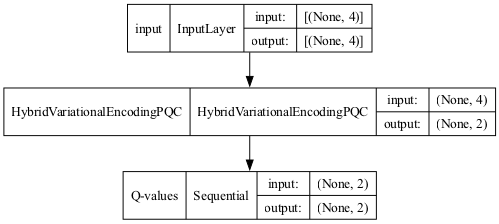

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70, to_file="model_classic.png")

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HybridVariationalEncodingPQ  (None, 2)                92        
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 Q-values (Sequential)       (None, 2)                 2         
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [15]:
x = np.random.random(size=(16,4,))
model([x])

<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.38282248, 0.65529966],
       [0.369394  , 0.63457334],
       [0.3453862 , 0.5056309 ],
       [0.4466657 , 0.613704  ],
       [0.3789647 , 0.629547  ],
       [0.43408078, 0.5745201 ],
       [0.38882577, 0.5137159 ],
       [0.4089002 , 0.6004227 ],
       [0.3801592 , 0.5282665 ],
       [0.37647727, 0.5363251 ],
       [0.36829612, 0.63520384],
       [0.45573935, 0.53261024],
       [0.3809028 , 0.5918867 ],
       [0.40693483, 0.59963745],
       [0.37490648, 0.55447453],
       [0.38772053, 0.64839405]], dtype=float32)>

## Training

In [16]:
gamma = 0.99
n_episodes = 2000

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = cl.deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 16
steps_per_update = 10 # Train the model every x steps
steps_per_target_update = 30 # Update the target model every x steps

optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

# optimizer_w_tups = list(zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]))

In [17]:
### Q-learning update function.

@tf.function
def Q_learning_update(states, actions, rewards, next_states, done, model, model_target, gamma, n_actions):
    
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)

    # Compute target Q-values and masks on sampled actions.
    # with catchtime() as t:
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1) * (1. - done))
    # print(f"{target_q_values=}")
    # print(f"[target_q_values] Execution time: {t():.4f} secs")
    
    masks = tf.one_hot(actions, n_actions)
    # print(f"{actions=}")
    # print(f"{masks=}")
    
    
    # with catchtime() as t:
    # Train the model using target Q-values.
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        # with catchtime() as t1:
        q_values = model([states])
        # print(f"[tape:eval] Execution time: {t1():.4f} secs")
        # print(f"{q_values=}")
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # print(f"{q_values_masked=}")
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)
    # print(f"[tape] Execution time: {t():.4f} secs")
        
    # with catchtime() as t:
    # Backprop.
    grads = tape.gradient(loss, model.trainable_variables)
    # for optimizer, w in optimizer_w_tups:
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
    # print(f"[backprop] Execution time: {t():.4f} secs")
        
    # # print(f"{loss=}")
    # # print(f"{grads=}")
    # # print(f"{masks=}")
    # print(f"{target_q_values=}")
    # print(f"{q_values=}")
    # print(f"{loss=}")
    # print(f"{grads=}")

In [18]:
def interact_env(state, model, epsilon, n_actions, env):
    # state_shape = state.shape
    # state = np.asarray(state).reshape((1, *state_shape)) # Reshape to (1, features) so that batch_size=1.
    # state = tf.convert_to_tensor([state]) # Reshape to (1, features) so that batch_size=1.
    state = np.asarray(state).reshape((1, 4)) # Reshape to (1, features) so that batch_size=1.
    
    # Select action.
    coin = np.random.random()
    if coin > epsilon: # Epsilon-greedy
        q_vals = model([state])
        action = int(tf.argmax(q_vals[0]).numpy())
    else: # Random action.
        action = np.random.choice(n_actions)
    
    next_state, reward, done, _, _ = env.step(action)
    next_state = np.asarray(next_state).reshape(state.shape)
    
    return dict(
        state=state,
        action=action,
        reward=reward,
        next_state=next_state,
        done=done,
    )

In [19]:
### Main training loop

# with tf.device("/gpu:0"):

env = gym.make('CartPole-v1')

episode_reward_history = []
step_count = 0
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    
    while True:
        # Interact with environment.
        interaction = interact_env(state, model, epsilon, n_actions, env)
        
        # Preserve interaction in the replay memory.
        replay_memory.append(interaction)
        
        state = interaction['next_state']
        episode_reward += interaction['reward']
        step_count += 1
        
        if step_count % steps_per_update == 0:
            training_batch = np.random.choice(replay_memory, size=batch_size) # Randomly select interactions from replay memory and train on them.
            
            Q_learning_update(
                states=np.asarray([x['state'] for x in training_batch]).squeeze(),
                actions=np.asarray([x['action'] for x in training_batch]).squeeze(),
                rewards=np.asarray([x['reward'] for x in training_batch], dtype=np.float32).squeeze(),
                next_states=np.asarray([x['next_state'] for x in training_batch]).squeeze(),
                done=np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze(),
                model=model,
                model_target=model_target,
                gamma=gamma,
                n_actions=n_actions,
                # optimizer_w_tups=optimizer_w_tups,
            )
            # 
            # 
            # 
            # Q_learning_update_new(np.asarray([x['state'] for x in training_batch]).squeeze(),
            #                   np.asarray([x['action'] for x in training_batch]).squeeze(),
            #                   np.asarray([x['reward'] for x in training_batch], dtype=np.float32).squeeze(),
            #                   np.asarray([x['next_state'] for x in training_batch]).squeeze(),
            #                   np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze(),
            #                   model, gamma, n_actions)
        
        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())
        
        if interaction['done']:
            break
        
    # Decay epsilon.
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    
    if (episode+1) % 10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(episode+1, n_episodes, avg_rewards))
        if avg_rewards >= 500.0:
            break
    
    # if episode > 50: break

Episode 10/2000, average last 10 rewards 23.9
Episode 20/2000, average last 10 rewards 17.9
Episode 30/2000, average last 10 rewards 19.9
Episode 40/2000, average last 10 rewards 19.0
Episode 50/2000, average last 10 rewards 19.7
Episode 60/2000, average last 10 rewards 16.5
Episode 70/2000, average last 10 rewards 21.0
Episode 80/2000, average last 10 rewards 14.8
Episode 90/2000, average last 10 rewards 17.0
Episode 100/2000, average last 10 rewards 16.4
Episode 110/2000, average last 10 rewards 18.6
Episode 120/2000, average last 10 rewards 22.7
Episode 130/2000, average last 10 rewards 24.1
Episode 140/2000, average last 10 rewards 19.0
Episode 150/2000, average last 10 rewards 21.2
Episode 160/2000, average last 10 rewards 20.2
Episode 170/2000, average last 10 rewards 20.3
Episode 180/2000, average last 10 rewards 17.9
Episode 190/2000, average last 10 rewards 20.9
Episode 200/2000, average last 10 rewards 21.1
Episode 210/2000, average last 10 rewards 16.3
Episode 220/2000, aver

In [22]:
# model.save('q_qlearning_cirq', save_format='tf')
model.save_weights('q_qlearning_cirq__weights')

In [23]:
model.load_weights('q_qlearning_cirq__weights')

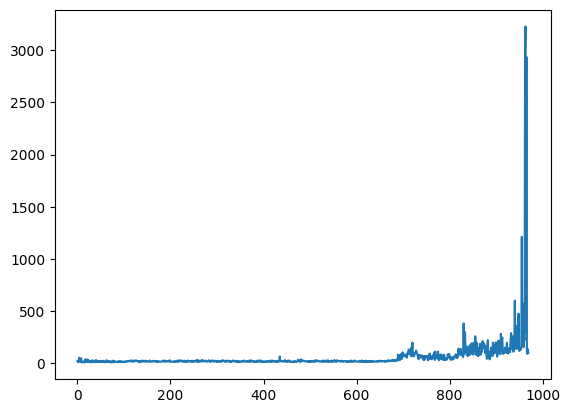

In [24]:
plt.plot(episode_reward_history)

----------

# OLD CODE

In [6]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

def generate_circuit_cirq(wires, n_layers):
    
    if isinstance(wires, int):
            wires = list(range(wires))
    elif isinstance(wires, (list, tuple)):
        wires = wires
    else:
        raise ValueError(f"Wires must either be an integer, list, or tuple; got {wires}")
    
    n_wires = len(wires)
    qubits = cirq.LineQubit.range(n_wires)
    
    
    ### Weights
    weights_var = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_wires})')
    weights_var = np.asarray(weights_var).reshape((n_layers + 1, n_wires, 3))
    #
    weights_enc = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_wires})')
    weights_enc = np.asarray(weights_enc).reshape((n_layers, n_wires))
    
    print(f"{weights_var.shape=}")
    print(f"{weights_enc.shape=}")
    
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, weights_var[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(weights_enc[l, i])(q) for i, q in enumerate(qubits))
    
    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, weights_var[n_layers, i]) for i, q in enumerate(qubits))
    
    return circuit, (weights_var, weights_enc)


_, (cirq_weights_var, cirq_weights_enc) = generate_circuit_cirq(4, 5)

# class CirqQuantumLayer(keras.layers.Layer):
#     def __init__(self,
#         wires: int | list[int],
#         n_layers: int,
#         observables: list | Callable[[list], list] | None = None,
#         initial_state: list | Callable[[list], None] = None,
#         ):
#         super().__init__()
        
#         if isinstance(wires, int):
#             wires = list(range(wires))
#         elif isinstance(wires, (list, tuple)):
#             wires = wires
#         else:
#             raise ValueError(f"Wires must either be an integer, list, or tuple; got {wires}")
#         self.n_wires = len(wires)
#         self.wires = wires

weights_var.shape=(6, 4, 3)
weights_enc.shape=(5, 4)


In [7]:
# device = qml.device('default.qubit')
# @qml.qnode(device=device)
# def quantum_circuit(wires, n_layers, observables, weights_var, weights_enc):
#     VariationalEncodingPQC(
#         weights_var=weights_var,
#         weights_enc=weights_enc,
#         n_layers=n_layers,
#         wires=wires,
#         )
#     if observables is not None:
#         res = [qml.expval(o) for o in observables]
#         return res

# class CustomQuantumLayer(keras.layers.Layer):
#     def __init__(self,
#         wires: int | list[int],
#         n_layers: int,
#         observables: list | Callable[[list], list] | None = None,
#         initial_state: list | Callable[[list], None] = None,
#         ):
#         super().__init__()
        
#         if isinstance(wires, int):
#             wires = list(range(wires))
#         elif isinstance(wires, (list, tuple)):
#             wires = wires
#         else:
#             raise ValueError(f"Wires must either be an integer, list, or tuple; got {wires}")
#         self.n_wires = len(wires)
#         self.wires = wires
        
#         self.set_observables(observables=observables)
        
#         self.n_layers = n_layers
#         self.initial_state = initial_state
        
        
#         ### Create trainable variables for this layer.
#         shape_weights_var, shape_weights_enc = VariationalEncodingPQC.shape(
#             n_layers=n_layers,
#             wires=wires,
#             )
#         print(f'got shape: {(shape_weights_var, shape_weights_enc)=}')
        
#         self.weights_var = tf.Variable(
#             initial_value=tf.random_uniform_initializer(minval=0., maxval=np.pi,)(shape=shape_weights_var, dtype='float32'),
#             trainable=True,
#             name='weights_var',
#             )
#         self.weights_enc = tf.Variable(
#             initial_value=tf.ones(shape=shape_weights_enc, dtype='float32'),
#             trainable=True,
#             name='weights_enc',
#             )
#         print('init vars')
        
#         ### Build quantum circuit.
#         # self.q_device = qml.device('default.qubit', wires=wires)
#         # self.q_qnode = qml.QNode(self.quantum_circuit, device=self.q_device)
#         self.q_qnode = quantum_circuit
#         print('build circuit')
        
        
#     def call(self, inputs):
        
#         inputs = tf.reshape(inputs, (-1, self.n_wires)) # Ensure shape is 2D with (batch, d_qubits)
        
#         print('pre-einsum')
#         weights_enc = tf.einsum("lqf,bq->blqf", self.weights_enc, inputs) # For each agent, encode each `input` state feature `q` on the `q-th` qubit and repeat encoding on same qubit for every layer `l`. Number of input features must match number of qubits.
#         print('post-einsum')
        
#         weights_var = self.weights_var
        
#         print('pre-eval')
#         # res = self.q_qnode(weights_var, weights_enc)
#         res = self.q_qnode(self.wires, self.n_layers, self.observables, weights_var, weights_enc)
#         print('post-eval')
#         res = tf.convert_to_tensor(res) # Ensure tensor.
#         res = tf.transpose(res) # Place batch dimension first.
#         # new_shape = tf.concat([batch_dim, tf.shape(res)[1:]], axis=0)
#         # res = tf.reshape(res, new_shape)
#         return res

#     def quantum_circuit(self, weights_var, weights_enc):
#         VariationalEncodingPQC(
#             weights_var=weights_var,
#             weights_enc=weights_enc,
#             n_layers=self.n_layers,
#             wires=self.wires,
#             )
#         return self.measure()
    
#     def measure(self) -> list | None:
#         """Returns list of expectations across all observables."""
#         if self.observables is not None:
#             res = [qml.expval(o) for o in self.observables]
#             return res
        
        
#     def set_observables(self, observables: list | Callable[[list], list] | None = None):
#         """Allows setting observables after circuit has been created."""
#         if observables is None:
#             self.observables = None
#         elif hasattr(observables, '__iter__') and not isinstance(observables, str):
#             self.observables = np.asarray(observables).tolist() # Ensure type is a Python list.
#         elif isinstance(observables, Callable):
#             self.observables = np.asarray(observables(self.wires)).tolist() # Ensure type is a Python list.
#         else:
#             raise ValueError(f"observables must either be a list or function; got `{observables}`")
        

In [8]:
class Rescaling(keras.layers.Layer):
    """Learnable rescaling from range [-1, 1] to range [0, 1]."""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)),
            dtype='float32',
            trainable=True,
            name='obs-weights',
            )
        
    def call(self, inputs):
        # inputs = tf.math.abs(inputs)
        # inputs = tf.cast(inputs, dtype='float32')
        return tf.math.multiply(
            (1+inputs)/2., # Rescale from [-1, 1] to range [0, 1].
            tf.repeat(self.w, repeats=tf.shape(inputs)[0], axis=0),
            )

In [9]:
def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)
    
    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))
    
    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_qubits})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))
    
    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))
    
    return circuit, list(params.flat), list(inputs.flat)


class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )
        
        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )
        
        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])
        
        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)        

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        print(f"{inputs=}")
        # print(f"{inputs.shape=}")
        # print(f"{inputs[0].shape=}")
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        # print(f"{tiled_up_inputs.shape=}")
        print(f"{self.lmbd=}")
        print(f"{tiled_up_inputs=}")
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        print(f"{scaled_inputs.shape=}")
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)
        
        return self.computation_layer([tiled_up_circuits, joined_vars])

In [10]:
def generate_model_Qlearning(n_wires, n_layers, observables, is_target):
    
    # circuit = AgentCircuit(
    #     wires=n_wires,
    #     n_layers=n_layers,
    #     observables=observables,
    # )
    # # circuit = MARLCircuit(
    # #     n_agents=1,
    # #     d_qubits=4,
    # #     n_layers=n_layers,
    # #     observables=observables,
    # #     # initial_state=lambda wires: entangle_agents_phi_plus(wires, d_qubits, n_agents),
    # # )
    # # qnode = circuit.qnode(device='lightning.gpu', interface='tf') # Set interface to TensorFlow.
    # # tf_device_kwargs = dict(
    # #     name='default.qubit.tf',
    # #     tensorflow_device='cuda',
    # # )
    # # qnode = circuit.qnode(device=tf_device_kwargs, interface='tf', diff_method="backprop") # Set interface to TensorFlow.
    # # qnode = circuit.qnode(device='default.qubit.tf', interface='tf', diff_method="backprop") # Set interface to TensorFlow.
    # # qnode = circuit.qnode(device='lightning.qubit', interface='tf') # Set interface to TensorFlow.
    # # qnode = circuit.qnode(device='default.qubit', diff_method="adjoint") # Set interface to TensorFlow.
    # # qnode = circuit.qnode(device='default.qubit', interface='tf') # Set interface to TensorFlow.
    # # qnode = circuit.qnode(device='cirq.simulator') # Set interface to TensorFlow.
    # qnode = circuit.qnode(device='default.qubit.tf', interface='tf') # Set interface to TensorFlow.
    # # qnode = circuit.qnode(device='lightning.qubit', interface=None) # Set interface to TensorFlow.
    # qlayer = circuit.get_keras_layer(name='ReUploadingPQC', qnode=qnode)
    
    
    # n_qubits = 4 # Dimension of the state vectors in CartPole
    # n_layers = 5 # Number of layers in the PQC
    # n_actions = 2 # Number of actions in CartPole
    
    
    
    #############

    qubits = cirq.GridQubit.rect(1, n_wires)
    ops = [cirq.Z(q) for q in qubits]
    observables = [ops[0]*ops[1], ops[2]*ops[3]] # Z_0*Z_1 for action 0 and Z_2*Z_3 for action 1
    # qlayer = ReUploadingPQC(qubits, n_layers, observables, activation='tanh')

    # model = keras.Sequential([
    #         keras.Input(shape=(n_wires,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
    #         qlayer,
    #         # CustomQuantumLayer(n_wires, n_layers, observables),
    #         # keras.layers.Lambda(lambda x: tf.math.abs(x)), # Convert complex to float via abs.
    #         keras.layers.Activation('tanh'), # Ensure outputs of PQC are in range [-1, 1].
    #         keras.Sequential([Rescaling(len(observables))], name=is_target*'Target'+'Q-values'),
    #     ],
    #     )
    # return model


    ##############
    
    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables, activation='tanh')([input_tensor])
    process = tf.keras.Sequential([Rescaling(len(observables))], name=is_target*"Target"+"Q-values")
    Q_values = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor], outputs=Q_values)

    return model
    

In [11]:
qml.device('cirq.simulator', wires=4).capabilities()

{'model': 'qubit',
 'tensor_observables': True,
 'supports_broadcasting': False,
 'supports_finite_shots': True,
 'supports_tensor_observables': True,
 'returns_probs': True,
 'returns_state': True}

In [12]:
# def generate_model_Qlearning_MARL(n_agents, d_qubits, n_layers, observables, is_target):

#     circuit = MARLCircuit(
#         n_agents=n_agents,
#         d_qubits=d_qubits,
#         n_layers=n_layers,
#         observables=observables,
#         initial_state=lambda wires: entangle_agents_phi_plus(wires, d_qubits, n_agents),
#     )
#     qnode = circuit.qnode(interface='tf') # Set interface to TensorFlow.
#     qlayer = circuit.get_keras_layer(name='MARL-ReUploadingPQCs', qnode=qnode)
    
#     model = keras.Sequential([
#             # Input shape must be 1D into the quantum layer, so use (n_agents, d_qubits,) followed by a reshape layer.
#             keras.Input(shape=(n_agents, d_qubits,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the combined observation vector shape for all agents.
#             keras.layers.Reshape(target_shape=(-1,)), # Ensure input to the quantum layer is 1D for total number of wires.
#             qlayer,
#             # keras.layers.Lambda(lambda x: tf.math.abs(x)), # Convert complex to float via abs.
#             keras.layers.Activation('tanh'), # Ensure outputs of PQC are in range [-1, 1].
#             keras.Sequential([Rescaling(len(observables))], name=is_target*'Target'+'Q-values'),
#         ],
#         )
#     return model, circuit
    

In [13]:
# env = gym.make('CartPole-v1')
n_actions = 2 # because `env.action_space.n == 2`
n_wires = 4 # because `env.observation_space.shape == (4,)`
# input_shape = (4,) # Shape of model input, which should match the observation vector shape `env.observation_space.shape == (4,)`

n_layers = 5 # Number of PQC layers.

In [14]:
# observables = np.array([
#     qml.PauliZ(wires=0) @ qml.PauliZ(wires=1), # Z0 Z1 (action 0 -- "left")
#     qml.PauliZ(wires=2) @ qml.PauliZ(wires=3), # Z2 Z3 (action 1 -- "right")
#     ])
# # observables = lambda wires: [
# #     qml.PauliZ(wires=0) @ qml.PauliZ(wires=1), # Z0 Z1 (action 0 -- "left")
# #     qml.PauliZ(wires=2) @ qml.PauliZ(wires=3), # Z2 Z3 (action 1 -- "right")
# #     ]

# circuit = AgentCircuit(
#     wires=n_wires,
#     n_layers=n_layers,
#     observables=observables,
# )

# # print(qml.draw(qnode, wire_order=list(range(n_wires)))())

In [15]:
# inputs = np.random.random(size=(16,4,))
# CustomQuantumLayer(wires=4, n_layers=5, observables=observables)(inputs)

In [16]:
model = generate_model_Qlearning(
    n_wires=n_wires,
    n_layers=n_layers,
    observables=None,
    is_target=False,
    )

model_target = generate_model_Qlearning(
    n_wires=n_wires,
    n_layers=n_layers,
    observables=None,
    is_target=True,
    )

print('setting weights')
model_target.set_weights(model.get_weights())

inputs=[<tf.Tensor 'Placeholder:0' shape=(None, 4) dtype=float32>]
self.lmbd=<tf.Variable 'lambdas:0' shape=(20,) dtype=float32>
tiled_up_inputs=<tf.Tensor 're-uploading_PQC/Tile_1:0' shape=(None, 20) dtype=float32>
scaled_inputs.shape=TensorShape([None, 20])
inputs=[<tf.Tensor 'Placeholder:0' shape=(None, 4) dtype=float32>]
self.lmbd=<tf.Variable 'lambdas:0' shape=(20,) dtype=float32>
tiled_up_inputs=<tf.Tensor 're-uploading_PQC/Tile_1:0' shape=(None, 20) dtype=float32>
scaled_inputs.shape=TensorShape([None, 20])
setting weights


In [17]:
# weights = model.layers[0].weights
# inputs = tf.convert_to_tensor(tf.constant(np.random.random(size=(16, 4,)), dtype='float32'))
# # inputs = [tf.convert_to_tensor(tf.constant(np.random.random(size=(4,)), dtype='float32')) for i in range(16)]

# # print(qml.draw(circuit, wire_order=list(range(circuit.n_wires)))(*weights, inputs))
# circuit.qnode()(*weights, inputs)

In [18]:
# tf.reduce_all(tf.reshape(tf.tile(weights[0], multiples=[16, 1, 1]), (16, 6, 4, 3))[0] == tf.reshape(tf.tile(weights[0], multiples=[16, 1, 1]), (16, 6, 4, 3))[-1])

In [19]:
# model(inputs)

In [20]:
# observables_MARL = np.array([
#     qml.PauliZ(wires=0) @ qml.PauliZ(wires=1) @ qml.PauliZ(wires=4) @ qml.PauliZ(wires=5), # Z0 Z1 Z4 Z5 (action 0 -- "left")
#     # -(qml.PauliZ(wires=0) @ qml.PauliZ(wires=1) @ qml.PauliZ(wires=4) @ qml.PauliZ(wires=5)), # - Z0 Z1 Z4 Z5 (action 0 -- "left")
#     qml.PauliZ(wires=2) @ qml.PauliZ(wires=3) @ qml.PauliZ(wires=6) @ qml.PauliZ(wires=7), # Z2 Z3 Z6 Z7 (action 1 -- "right")
#     # -(qml.PauliZ(wires=2) @ qml.PauliZ(wires=3) @ qml.PauliZ(wires=6) @ qml.PauliZ(wires=7)), # - Z2 Z3 Z6 Z7 (action 1 -- "right")
#     ])

# model_MARL, circuit_MARL = generate_model_Qlearning_MARL(
#     n_agents=2,
#     d_qubits=4,
#     n_layers=n_layers,
#     observables=observables_MARL,
#     is_target=False,
#     )

# # model_MARL.layers[0].weights[1].shape

# # # Get shapes for weights of quantum layer.
# # [w.shape for w in model.layers[0].weights]

In [21]:
# s = np.random.random(size=(3, 2, 4,))
# model_MARL([s])

In [22]:
# model.get_layer('ReUploadingPQC').weights[0].shape, model.get_layer('ReUploadingPQC').weights[1].shape

In [23]:
# model_MARL.get_layer('MARL-ReUploadingPQCs').weights[0].shape, model_MARL.get_layer('MARL-ReUploadingPQCs').weights[1].shape

In [24]:
# # Example override of MARL weights with weights from a local agent model.
# aidx = 0 # Agent index to update.
# updated_agents_weights_var = tf.stack([])
# updated_agents_weights_var = model_MARL.get_layer('MARL-ReUploadingPQCs').weights[0]
# # updated_agents_weights_var.scatter_update(model.get_layer('ReUploadingPQC').weights[0][:])
# # updated_agents_weights_var = tf.tensor_scatter_nd_update(updated_agents_weights_var, [[aidx, 6, 4, 3]], model.get_layer('ReUploadingPQC').weights[0])
# # updated_agents_weights_var[aidx].assign(model.get_layer('ReUploadingPQC').weights[0])
# # updated_agents_weights_enc = model_MARL.get_layer('MARL-ReUploadingPQCs').weights[1]
# # updated_agents_weights_enc[aidx].assign(model.get_layer('ReUploadingPQC').weights[1])
# # updated_agents_weights_enc
# updated_agents_weights_var
# # model_MARL.get_layer('MARL-ReUploadingPQCs').set_weights([updated_agents_weights_var, updated_agents_weights_enc])

In [25]:
# tf.reduce_all(model_MARL.get_layer('MARL-ReUploadingPQCs').get_weights()[aidx][0] == model.get_layer('ReUploadingPQC').weights[0])
# tf.reduce_all(model_MARL.get_layer('MARL-ReUploadingPQCs').get_weights()[aidx][1] == model.get_layer('ReUploadingPQC').weights[1])

In [26]:
# model_MARL.get_layer('MARL-ReUploadingPQCs').get_weights()[aidx][1].shape, model.get_layer('ReUploadingPQC').weights[1].shape

In [27]:
# tf.keras.utils.plot_model(model_MARL, show_shapes=True, dpi=70, to_file="model_MARL.png")

In [28]:
# # print(qml.draw(circuit, wire_order=list(range(circuit.n_wires)))(*model.layers[0].weights))
# qml.draw_mpl(circuit_MARL, wire_order=list(range(circuit.n_wires)))(*model_MARL.layers[1].weights)

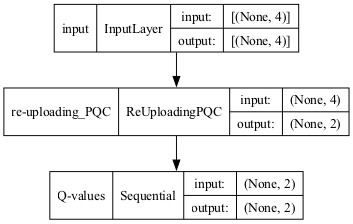

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70, to_file="model_classic.png")

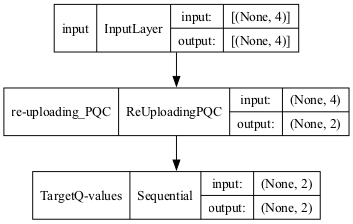

In [30]:
tf.keras.utils.plot_model(model_target, show_shapes=True, dpi=70, to_file="model_classic_target.png")

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 re-uploading_PQC (ReUploadi  (None, 2)                92        
 ngPQC)                                                          
                                                                 
 Q-values (Sequential)       (None, 2)                 2         
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [32]:
# ### Visualize the circuit.
# weight_shapes = circuit.weight_shapes
# weights = {
#     k: np.random.uniform(low=0., high=np.pi, size=s)
#     for k, s in weight_shapes.items()
# }
# # shape_var, shape_enc = circuit.shape
# # weights_var = np.random.uniform(low=0., high=np.pi, size=shape_var)
# # weights_enc = np.random.uniform(low=0., high=np.pi, size=shape_enc)
# print(qml.draw(circuit, wire_order=circuit.wires)(**weights))

In [33]:
def interact_env(state, model, epsilon, n_actions, env):
    # state_shape = state.shape
    # state = np.asarray(state).reshape((1, *state_shape)) # Reshape to (1, features) so that batch_size=1.
    # state = tf.convert_to_tensor([state]) # Reshape to (1, features) so that batch_size=1.
    state = np.asarray(state).reshape((1, 4)) # Reshape to (1, features) so that batch_size=1.
    # state = np.asarray(state).reshape((4,)) # Reshape to (1, features) so that batch_size=1.
    
    # Select action.
    coin = np.random.random()
    if coin > epsilon: # Epsilon-greedy
        q_vals = model([state])
        action = int(tf.argmax(q_vals[0]).numpy())
    else: # Random action.
        action = np.random.choice(n_actions)
    
    next_state, reward, done, _, _ = env.step(action)
    next_state = np.asarray(next_state).reshape(state.shape)
    
    return dict(
        state=state,
        action=action,
        reward=reward,
        next_state=next_state,
        done=done,
    )

In [34]:
gamma = 0.99
n_episodes = 2000

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = cl.deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 2
steps_per_update = 10 # Train the model every x steps
steps_per_target_update = 30 # Update the target model every x steps

optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

# optimizer_w_tups = list(zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]))
optimizer_w_tups = zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out])

In [35]:
### Q-learning update function.

# @tf.function
def Q_learning_update(
    states,
    actions, 
    rewards, 
    next_states, 
    done, 
    model, 
    model_target, 
    gamma, 
    n_actions, 
    optimizer_w_tups,
    ):
    
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)
    
    print(f"{states=}")

    # Compute target Q-values and masks on sampled actions.
    # with catchtime() as t:
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1) * (1. - done))
    # print(f"{target_q_values=}")
    # print(f"[target_q_values] Execution time: {t():.4f} secs")
    
    masks = tf.one_hot(actions, n_actions)
    # print(f"{actions=}")
    # print(f"{masks=}")
    
    
    # with catchtime() as t:
    # Train the model using target Q-values.
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        # with catchtime() as t1:
        q_values = model([states])
        # print(f"[tape:eval] Execution time: {t1():.4f} secs")
        # print(f"{q_values=}")
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # print(f"{q_values_masked=}")
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)
    # print(f"[tape] Execution time: {t():.4f} secs")
        
    # with catchtime() as t:
    # Backprop.
    grads = tape.gradient(loss, model.trainable_variables)
    
    # optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    # optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    # optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
    # optimizer_w_tups = zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out])
    for optimizer, w in optimizer_w_tups:
    # for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
    # print(f"[backprop] Execution time: {t():.4f} secs")
        
    # # print(f"{loss=}")
    # # print(f"{grads=}")
    # # print(f"{masks=}")
    # print(f"{target_q_values=}")
    # print(f"{q_values=}")
    # print(f"{loss=}")
    # print(f"{grads=}")

In [36]:
###### NEW Q-LEARNING UPDATE
# @tf.function
def Q_learning_update_new(states, actions, rewards, next_states, done, model, gamma, n_actions, model_target):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)

    # Compute their target q_values and the masks on sampled actions
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1) * (1.0 - done))
    masks = tf.one_hot(actions, n_actions)

    # Train the model on the states and target Q-values
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        q_values = model([states])
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)

    # Backpropagation
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
    
    
    # print(f"{masks=}")
    # print(f"{target_q_values=}")
    # print(f"{q_values=}")
    # print(f"{loss=}")
    # print(f"{grads=}")
###### NEW Q-LEARNING UPDATE

In [37]:
original_trainable_variables = model.trainable_variables # Preserve
for v in original_trainable_variables: print(v)

<tf.Variable 'thetas:0' shape=(1, 72) dtype=float32, numpy=
array([[2.2372582 , 2.5880358 , 3.06306   , 3.085846  , 1.0635768 ,
        3.1228194 , 1.1418483 , 3.0050817 , 1.905281  , 2.785892  ,
        0.5004826 , 0.6447723 , 1.9543257 , 2.0800443 , 2.447851  ,
        2.3334134 , 2.1009912 , 0.3908801 , 2.5953097 , 0.71879137,
        0.7986804 , 3.040161  , 1.6241587 , 0.07939886, 2.0816183 ,
        0.84860075, 0.03480743, 0.69438773, 1.1510717 , 2.4947326 ,
        0.08011679, 1.1260244 , 1.8323342 , 2.179437  , 1.9240333 ,
        0.7027988 , 1.6664402 , 3.0567665 , 0.784517  , 2.8431237 ,
        0.28822324, 0.69219875, 1.0673001 , 0.8905047 , 2.25244   ,
        0.18145877, 1.030313  , 3.0538795 , 2.6694224 , 2.385821  ,
        1.135508  , 2.664714  , 0.28354713, 2.111842  , 0.9070527 ,
        2.223006  , 1.1406634 , 2.441232  , 2.972549  , 0.73719424,
        0.07695109, 0.9957925 , 2.2279787 , 1.7951983 , 0.353165  ,
        1.5548764 , 1.2224962 , 0.70328975, 0.6142481 , 

In [38]:
x = np.random.random(size=(16, 4,))
tf.tile(x, multiples=[1, 5]).shape

TensorShape([16, 20])

In [39]:
######### NEW TRAINING LOOP
env = gym.make("CartPole-v1")
    
episode_reward_history = []
step_count = 0
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    
    while True:
        # Interact with env
        interaction = interact_env(state, model, epsilon, n_actions, env)
        
        # Store interaction in the replay memory
        replay_memory.append(interaction)
        
        state = interaction['next_state']
        episode_reward += interaction['reward']
        step_count += 1
        # print(f"{state.shape=}")
        
        # Update model
        if step_count % steps_per_update == 0:
            # Sample a batch of interactions and update Q_function
            training_batch = np.random.choice(replay_memory, size=batch_size)
            #
            #
            Q_learning_update(
                states=np.asarray([x['state'] for x in training_batch]).squeeze(),
                actions=np.asarray([x['action'] for x in training_batch]).squeeze(),
                rewards=np.asarray([x['reward'] for x in training_batch], dtype=np.float32).squeeze(),
                next_states=np.asarray([x['next_state'] for x in training_batch]).squeeze(),
                done=np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze(),
                model=model,
                model_target=model_target,
                gamma=gamma,
                n_actions=n_actions,
                optimizer_w_tups=optimizer_w_tups,
                )
            #
            #
            #
            #
            # Q_learning_update(
            #     states=np.asarray([x['state'] for x in training_batch]).squeeze(),
            #     actions=np.asarray([x['action'] for x in training_batch]).squeeze(),
            #     rewards=np.asarray([x['reward'] for x in training_batch], dtype=np.float32).squeeze(),
            #     next_states=np.asarray([x['next_state'] for x in training_batch]).squeeze(),
            #     done=np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze(),
            #     model=model,
            #     model_target=model_target,
            #     gamma=gamma,
            #     n_actions=n_actions,
            #     optimizer_w_tups=optimizer_w_tups,
            # )
            #
            #
            #
            #
            # Q_learning_update_new(
            #     np.asarray([x['state'] for x in training_batch]).squeeze(),
            #     np.asarray([x['action'] for x in training_batch]).squeeze(),
            #     np.asarray([x['reward'] for x in training_batch], dtype=np.float32).squeeze(),
            #     np.asarray([x['next_state'] for x in training_batch]).squeeze(),
            #     np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze(),
            #     model,
            #     gamma,
            #     n_actions,
            #     model_target,
            #     )
        
        # Update target model
        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())
        
        # Check if the episode is finished
        if interaction['done']:
            break

    # Decay epsilon
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    if (episode+1)%10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(
            episode+1, n_episodes, avg_rewards))
        if avg_rewards >= 500.0:
            break
        
    if episode > 10: break
######### NEW TRAINING LOOP

states=<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 0.03672619,  0.00953293, -0.01919124, -0.02750128],
       [ 0.03263681,  0.20446923, -0.01286928, -0.31609806]],
      dtype=float32)>
inputs=[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 0.03691685,  0.20492478, -0.01974127, -0.32617694],
       [ 0.03672619,  0.00953293, -0.01919124, -0.02750128]],
      dtype=float32)>]
self.lmbd=<tf.Variable 'lambdas:0' shape=(20,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)>
tiled_up_inputs=<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[ 0.03691685,  0.20492478, -0.01974127, -0.32617694,  0.03691685,
         0.20492478, -0.01974127, -0.32617694,  0.03691685,  0.20492478,
        -0.01974127, -0.32617694,  0.03691685,  0.20492478, -0.01974127,
        -0.32617694,  0.03691685,  0.20492478, -0.01974127, -0.32617694],
       [ 0.03672619,  0.00953293, -0.01919124, -0.02750128, 

inputs=[<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.03818585, -0.1952429 ,  0.03412551,  0.34452286]],
      dtype=float32)>]
self.lmbd=<tf.Variable 'lambdas:0' shape=(20,) dtype=float32, numpy=
array([0.9990014 , 1.0009993 , 1.0009961 , 0.9990004 , 0.99900234,
       1.0009993 , 0.9990079 , 1.0009995 , 0.9990018 , 0.9990004 ,
       0.9990014 , 1.0009999 , 0.9990022 , 0.9990003 , 0.9990014 ,
       0.99900013, 0.99904734, 1.0009997 , 1.0009965 , 1.0009928 ],
      dtype=float32)>
tiled_up_inputs=<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[-0.03818585, -0.1952429 ,  0.03412551,  0.34452286, -0.03818585,
        -0.1952429 ,  0.03412551,  0.34452286, -0.03818585, -0.1952429 ,
         0.03412551,  0.34452286, -0.03818585, -0.1952429 ,  0.03412551,
         0.34452286, -0.03818585, -0.1952429 ,  0.03412551,  0.34452286]],
      dtype=float32)>
scaled_inputs.shape=TensorShape([1, 20])
states=<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 0.07676628,  

In [45]:
x = zip([chr(ord('a')+i) for i in range(10)], [i for i in range(10)])
x

In [46]:
for a in x:
    print(a)

('a', 0)
('b', 1)
('c', 2)
('d', 3)
('e', 4)
('f', 5)
('g', 6)
('h', 7)
('i', 8)
('j', 9)


In [47]:
x

In [ ]:
### Main training loop

# with tf.device("/gpu:0"):

env = gym.make('CartPole-v1')

episode_reward_history = []
step_count = 0
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    
    while True:
        # Interact with environment.
        interaction = interact_env(state, model, epsilon, n_actions, env)
        
        # Preserve interaction in the replay memory.
        replay_memory.append(interaction)
        
        state = interaction['next_state']
        episode_reward += interaction['reward']
        step_count += 1
        
        if step_count % steps_per_update == 0:
            training_batch = np.random.choice(replay_memory, size=batch_size) # Randomly select interactions from replay memory and train on them.
            
            Q_learning_update(
                states=np.asarray([x['state'] for x in training_batch]).squeeze(),
                actions=np.asarray([x['action'] for x in training_batch]).squeeze(),
                rewards=np.asarray([x['reward'] for x in training_batch], dtype=np.float32).squeeze(),
                next_states=np.asarray([x['next_state'] for x in training_batch]).squeeze(),
                done=np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze(),
                model=model,
                model_target=model_target,
                gamma=gamma,
                n_actions=n_actions,
                optimizer_w_tups=optimizer_w_tups,
            )
        
        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())
        
        if interaction['done']:
            break
        
    # Decay epsilon.
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    
    if (episode+1) % 10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(episode+1, n_episodes, avg_rewards))
        if avg_rewards >= 500.0:
            break
    
    if episode > 10: break

inputs=[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-0.03445966,  0.1672034 , -0.01985493, -0.32845902],
       [-0.03389587, -0.02818938, -0.01925969, -0.02976223]],
      dtype=float32)>]
self.lmbd=<tf.Variable 'lambdas:0' shape=(20,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)>
tiled_up_inputs=<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[-0.03445966,  0.1672034 , -0.01985493, -0.32845902, -0.03445966,
         0.1672034 , -0.01985493, -0.32845902, -0.03445966,  0.1672034 ,
        -0.01985493, -0.32845902, -0.03445966,  0.1672034 , -0.01985493,
        -0.32845902, -0.03445966,  0.1672034 , -0.01985493, -0.32845902],
       [-0.03389587, -0.02818938, -0.01925969, -0.02976223, -0.03389587,
        -0.02818938, -0.01925969, -0.02976223, -0.03389587, -0.02818938,
        -0.01925969, -0.02976223, -0.03389587, -0.02818938, -0.01925969,
        -0.02976223, -0.03389587, -0.0281

In [529]:
# (2, 4)
inputs = np.array([[-0.01039682,  0.01605072,  0.0029838 ,  0.03860417], [ 0.01260861,  0.21097969, -0.0169554 , -0.2498462 ]])

# (5, 4, 1)
weights_enc = np.array([[[1.000054  ],
        [1.0019959 ],
        [1.0019536 ],
        [1.0019972 ]],

       [[1.0000376 ],
        [0.9999973 ],
        [0.99996847],
        [1.0000407 ]],

       [[1.001989  ],
        [0.9980035 ],
        [1.0019749 ],
        [1.000001  ]],

       [[1.0000042 ],
        [1.0000086 ],
        [1.0000173 ],
        [1.0019947 ]],

       [[0.99999315],
        [0.99800795],
        [1.0000461 ],
        [0.9999987 ]]], dtype='float32')
weights_enc = weights_enc.squeeze()


(inputs[0] * weights_enc)

array([[-0.01039738,  0.01608276,  0.00298963,  0.03868127],
       [-0.01039721,  0.01605068,  0.00298371,  0.03860574],
       [-0.0104175 ,  0.01601867,  0.00298969,  0.03860421],
       [-0.01039686,  0.01605086,  0.00298385,  0.03868117],
       [-0.01039675,  0.01601875,  0.00298394,  0.03860412]])

In [535]:
(inputs[1] * weights_enc)

array([[ 0.01260929,  0.21140079, -0.01698852, -0.2503452 ],
       [ 0.01260908,  0.21097912, -0.01695487, -0.24985636],
       [ 0.01263369,  0.21055847, -0.01698889, -0.24984644],
       [ 0.01260866,  0.2109815 , -0.01695569, -0.25034458],
       [ 0.01260852,  0.21055941, -0.01695618, -0.24984587]])

In [538]:
np.einsum("lqf,bq->blqf", weights_enc[..., None], inputs).squeeze()[0] == (inputs[0] * weights_enc)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [ ]:
# =====
# inputs=<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
# array([[-0.01039682,  0.01605072,  0.0029838 ,  0.03860417],
#        [ 0.01260861,  0.21097969, -0.0169554 , -0.2498462 ]],
#       dtype=float32)>
# before: weights_enc=<tf.Tensor: shape=(5, 4, 1), dtype=float32, numpy=
# array([[[1.000054  ],
#         [1.0019959 ],
#         [1.0019536 ],
#         [1.0019972 ]],

#        [[1.0000376 ],
#         [0.9999973 ],
#         [0.99996847],
#         [1.0000407 ]],

#        [[1.001989  ],
#         [0.9980035 ],
#         [1.0019749 ],
#         [1.000001  ]],

#        [[1.0000042 ],
#         [1.0000086 ],
#         [1.0000173 ],
#         [1.0019947 ]],

#        [[0.99999315],
#         [0.99800795],
#         [1.0000461 ],
#         [0.9999987 ]]], dtype=float32)>
# after: weights_enc=<tf.Tensor: shape=(2, 5, 4, 1), dtype=float32, numpy=
# array([[[[-0.01039738],
#          [ 0.01608276],
#          [ 0.00298963],
#          [ 0.03868127]],

#         [[-0.01039721],
#          [ 0.01605068],
#          [ 0.00298371],
#          [ 0.03860573]],

#         [[-0.0104175 ],
#          [ 0.01601868],
#          [ 0.0029897 ],
#          [ 0.0386042 ]],

#         [[-0.01039687],
#          [ 0.01605086],
#          [ 0.00298386],
#          [ 0.03868117]],

#         [[-0.01039675],
#          [ 0.01601875],
#          [ 0.00298394],
#          [ 0.03860411]]],


#        [[[ 0.0126093 ],
#          [ 0.21140078],
#          [-0.01698852],
#          [-0.2503452 ]],

#         [[ 0.01260909],
#          [ 0.21097912],
#          [-0.01695487],
#          [-0.24985637]],

#         [[ 0.01263369],
#          [ 0.21055846],
#          [-0.01698889],
#          [-0.24984644]],

#         [[ 0.01260867],
#          [ 0.2109815 ],
#          [-0.01695569],
#          [-0.25034457]],

#         [[ 0.01260853],
#          [ 0.2105594 ],
#          [-0.01695618],
#          [-0.24984588]]]], dtype=float32)>

In [460]:
model.trainable_variables

[<tf.Variable 'weights_var:0' shape=(6, 4, 3) dtype=float32, numpy=
 array([[[0.9805262 , 2.5970278 , 2.1508203 ],
         [0.02007758, 2.472989  , 1.2282661 ],
         [0.9203254 , 3.1179914 , 3.0089736 ],
         [1.7464586 , 0.51630473, 0.42340934]],
 
        [[0.41462833, 1.6811546 , 1.7945408 ],
         [1.6022853 , 1.5148928 , 0.48847726],
         [1.1644031 , 1.5469987 , 1.7803334 ],
         [0.6535356 , 0.5715202 , 3.1369405 ]],
 
        [[1.1618369 , 1.1905388 , 2.425289  ],
         [2.1439352 , 1.255527  , 2.4622328 ],
         [2.133518  , 2.3068001 , 1.7332988 ],
         [0.3449569 , 2.0372598 , 3.1062958 ]],
 
        [[2.5762544 , 2.212892  , 3.0082142 ],
         [0.07117579, 2.9414892 , 2.0472023 ],
         [0.99574083, 0.0045045 , 2.8930953 ],
         [1.19997   , 2.425756  , 2.8760033 ]],
 
        [[1.8057718 , 2.4933574 , 1.3486687 ],
         [0.60163903, 2.3402739 , 1.3109922 ],
         [2.5687842 , 0.6329979 , 2.0295756 ],
         [0.5188675 , 1.407

In [459]:
updated_trainable_variables = model.trainable_variables # Preserve
for v in updated_trainable_variables: print(v)

<tf.Variable 'weights_var:0' shape=(6, 4, 3) dtype=float32, numpy=
array([[[0.9805262 , 2.5970278 , 2.1508203 ],
        [0.02007758, 2.472989  , 1.2282661 ],
        [0.9203254 , 3.1179914 , 3.0089736 ],
        [1.7464586 , 0.51630473, 0.42340934]],

       [[0.41462833, 1.6811546 , 1.7945408 ],
        [1.6022853 , 1.5148928 , 0.48847726],
        [1.1644031 , 1.5469987 , 1.7803334 ],
        [0.6535356 , 0.5715202 , 3.1369405 ]],

       [[1.1618369 , 1.1905388 , 2.425289  ],
        [2.1439352 , 1.255527  , 2.4622328 ],
        [2.133518  , 2.3068001 , 1.7332988 ],
        [0.3449569 , 2.0372598 , 3.1062958 ]],

       [[2.5762544 , 2.212892  , 3.0082142 ],
        [0.07117579, 2.9414892 , 2.0472023 ],
        [0.99574083, 0.0045045 , 2.8930953 ],
        [1.19997   , 2.425756  , 2.8760033 ]],

       [[1.8057718 , 2.4933574 , 1.3486687 ],
        [0.60163903, 2.3402739 , 1.3109922 ],
        [2.5687842 , 0.6329979 , 2.0295756 ],
        [0.5188675 , 1.4077289 , 1.9021418 ]],

   

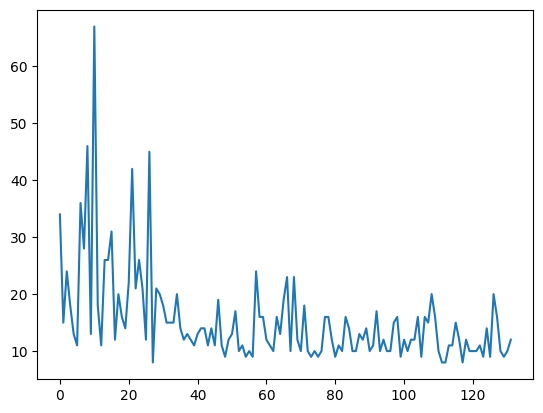

In [283]:
plt.plot(episode_reward_history)

In [40]:
env = gym.make('CartPole-v1')
epsilon = 0

state, _ = env.reset()
trajectory = []
for t in range(100):
    traj = interact_env(state, model, epsilon, n_actions, env)
    trajectory.append(traj)
    if traj['done']:
        break

trajectory

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


[{'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[ 0.00623899, -0.18428296,  0.00549074,  0.29789397]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[ 0.00255333, -0.37948275,  0.01144862,  0.5923035 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[-0.00503632, -0.57476306,  0.02329469,  0.8885706 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[-0.01653158, -0.7701933 ,  0.0410661 ,  1.1884844 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.0054206

In [44]:
def render_episode_as_gif_frames(env_name, actor, max_steps):
    env = gym.make(env_name, render_mode='rgb_array')
    
    state, _ = env.reset()
    
    state = tf.constant(state, dtype=tf.float32)
    screen = env.render()
    images = [Image.fromarray(screen)]
    
    for i in range(1, max_steps+1):
        state = tf.expand_dims(state, 0)
        action_probs = actor(state)
        action = np.argmax(np.squeeze(action_probs))
        
        state, reward, done, _, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)
        
        screen = env.render()
        images.append(Image.fromarray(screen))
        
        if done:
            break

    return images

def save_frames_as_gif(frames: list[Image.Image], path: Path, **kwargs):
    frames[1].save(
        path,
        save_all=True,
        append_images=frames[2:],
        optimize=False,
        duration=40,
        loop=0,
        **kwargs,
    )
    
import IPython.display
def display_gif(path: Path) -> IPython.display.DisplayHandle:
    return display(
        IPython.display.Image(
            data=open(path,'rb').read(), format='png'),
        )

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


rendering 10 frames to GIF ./images/gym_CartPole.gif


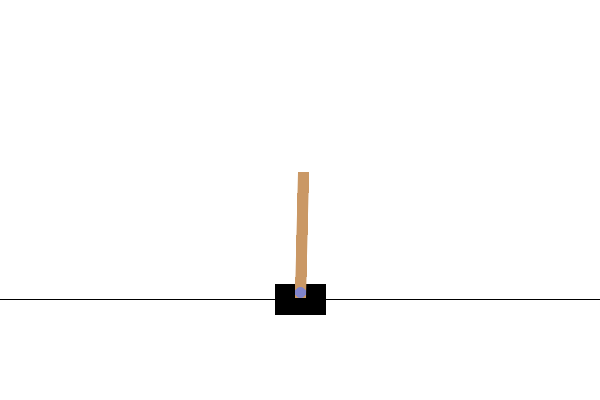

In [45]:
gif_path = './images/gym_CartPole.gif'
frames = render_episode_as_gif_frames('CartPole-v1', model, 100)
print(f"rendering {len(frames)} frames to GIF {gif_path}")
save_frames_as_gif(frames, gif_path)
display_gif(gif_path)